# 2D localization from self-motion
*Maxwell Pollack*

An agent accelerates randomly within a square environment of side length $L$ with inelastic boundaries. With $x^{0,i} \sim \mathcal{U}(0,l)$, $v^{0,i} = 0$, and $\Delta t=1$,

$$
\begin{split}
a^{t,i}_\text{self} & \sim \mathcal{N}(0,\mu) \\
v^{t,i} & = v^{t-1,i} + a^{t,i}_\text{self} \\
x^{t,i} & = max\big( 0, min(L, x^{t-1,i} + v^{t,i}) \big) \\
a^{t,i}_{\text{env}} & = -v^{t,i} \big( H(x^{t-1,i} + v^{t,i} - L) + H(-x^{t-1,i}-v^{t,i}) \big)\\
v^{t,i} & = v^{t,i} + a^{t,i}_\text{env}
\end{split}$$

are computed for each time step $t = \{0,...,T-1\}$ and dimension $i=\{1,2\}$, where $H$ is the Heaviside step function.

In [82]:
import torch

def simulate(trials=1, T=256, L=16, mu=0.1, n_dim=2):
    
    input = torch.zeros(trials,T,2*n_dim)
    x = torch.rand(trials,T,n_dim)*(L-1)
    v = torch.zeros(trials,T,n_dim)
    
    for t in range(1,T):
        
        a_self = mu * torch.randn(trials,n_dim)
        v[:,t] = v[:,t-1] + a_self
        x[:,t] = torch.clamp(x[:,t-1] + v[:,t], 0, L-1)
        a_env = torch.where((x[:,t-1]+v[:,t] > L-1) | (x[:,t-1]+v[:,t] < 0), -v[:,t], torch.zeros(1))
        v[:,t] += a_env
        
        input[:,t] = torch.cat((a_self, a_env), 1)

    places = torch.flatten(torch.stack(torch.meshgrid(n_dim*[torch.arange(float(L))]), dim=-1), end_dim=-2)
    target = torch.prod(torch.relu(1 - abs(x.unsqueeze(2) - places.expand(1,T,-1,-1))), dim=-1)
    
    return (input, target, x, v)

## Network

The components $a^{t,i}_\text{self}$ and $a^{t,i}_\text{env}$ are input to a [simple RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network#Elman_networks_and_Jordan_networks), trained with [Adam](https://arxiv.org/abs/1412.6980) to minimize the mean squared error between its output and the set of target activations

$$z^{t,k}_\text{target} = max\big(0, 1-|x^{t,0}-k//L|\big) * max\big(0, 1-|x^{t,1}-k\%L|\big) \text{,}$$

where $k=\{0,...,L^2-1\}$ is the output neuron index. This mimics a unit-spaced $L \times L$ grid of [place cells](https://en.wikipedia.org/wiki/Place_cell) with a single "bump" of activity tracking the agent's location. 

**Thereby, the RNN is tasked with inferring the agent's location in the environment from its self-imposed and environmentally-imposed acceleration.**

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(n_input, n_hidden, batch_first=True, nonlinearity='relu')
        self.linear = torch.nn.Linear(n_hidden, n_output)

    def forward(self, input):
        hidden = self.rnn(input)[0]
        return (torch.nn.functional.leaky_relu(self.linear(hidden)), hidden)

T = 256
L = 16

network = Network(n_input=4, n_hidden=L**2, n_output=L**2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

for trial in range(5*10**5):
    
    input, target, x, v = simulate(1, T, L)
    output, hidden = network(input)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

## Visualization

[Watch on Google Drive](https://drive.google.com/file/d/1AeZrL8PV9JEUxmn4YyEYh9oN6AYe_Khk/view?usp=sharing)

The activity of the network is visualized and animated. Hidden neurons are shown sorted in 2D by their input weights from $\vec a_\text{self}$ to illustrate how the network activity tracks **velocity** by integrating **acceleration** across time steps.

The network learns to update its location estimate (the spatial distribution of its output activity) in a Bayesian manner. Each collision with a boundary collapses the normal component of the output activity to the boundary coordinate, which then slowly widens again as path integration errors reaccumulate. The network also narrows its output activity by inferring where it could *not* be during path integration (e.g. if the agent moves 5 steps to the right and doesn't encounter a boundary, it could not have begun less than 5 steps from the right boundary). Visually, this looks like the output activity (moving with the agent) being *squash-deformed* against the boundary.

In [ ]:
%matplotlib inline
from matplotlib import animation, pyplot as plt
from matplotlib.patches import ConnectionPatch, Circle

input, target, x, v = simulate(1, 10**6, L)
output, hidden = network(input)

# Iteratively sort hidden cells row-wise by a_self^0 weights and column-wise by a_self^1 weights.
Win = next(network.parameters())
h_sorted = torch.argsort(Win[:,1]).view(L,L)
for _ in range(128):
    h_sorted = h_sorted.gather(0, torch.argsort(Win[h_sorted,0], dim=0))
    h_sorted = h_sorted.gather(1, torch.argsort(Win[h_sorted,1]))
hidden = hidden[...,h_sorted.flatten()]
    
fig,ax = plt.subplots(1,3, figsize=(13,7), gridspec_kw={'width_ratios':[1,L,L]})
plt.close()

plt.rcParams['font.size'] = 15

frames = [[ax[0].imshow(input[0,t].view(4,1).data.numpy(), vmin=0, vmax=0.5),
           ax[0].annotate(r'$\vec a_{self}$', (-0.25,0.75), xytext=(-3,0.75),
                          xycoords='axes fraction', va='center', annotation_clip=False,
                          arrowprops=dict(arrowstyle='-[')),
           ax[0].annotate(r'$\vec a_{env}$', (-0.25,0.25), xytext=(-3,0.25),
                          xycoords='axes fraction', va='center', annotation_clip=False,
                          arrowprops=dict(arrowstyle='-[')),
           ax[0].add_patch(ConnectionPatch((1,0.5),(0,0.5),'axes fraction',
                                           mutation_scale=20, axesA=ax[0],
                                           axesB=ax[1], arrowstyle='->')),
           ax[0].set_title('Input'),
           ax[1].imshow(hidden[0,t].view(L,L).data.numpy().T, vmin=0, vmax=0.5),
           ax[1].add_patch(ConnectionPatch((0.55,0),(0.45,0),'axes fraction',
                                           mutation_scale=20, arrowstyle='->',
                                           connectionstyle='arc, angleA=-90, angleB=-90,'+
                                           'rad=15, armA=20, armB=20')),
           ax[1].add_patch(ConnectionPatch((1,0.5),(0,0.5),'axes fraction', mutation_scale=20,
                                           axesA=ax[1], axesB=ax[2], arrowstyle='->')),
           ax[1].set_title('Hidden'),
           ax[2].imshow(output[0,t].view(L,L).data.numpy().T, vmin=0, vmax=0.5),
           ax[2].add_patch(Circle(x[0,t], radius=0.5, facecolor='r', edgecolor=None)),
           ax[2].set_title('Output')]
          
          for t in range(512)]

for axis in ax:
    axis.axis('off')

plt.rcParams['animation.html'] = 'html5'
animation.ArtistAnimation(fig, frames, interval=100)

## Receptive Fields of the Hidden cells

The mean activation of each hidden cell at each location in the environment is plotted on a 2D grid sorted by their input weights from $\vec a_\text{self}$.

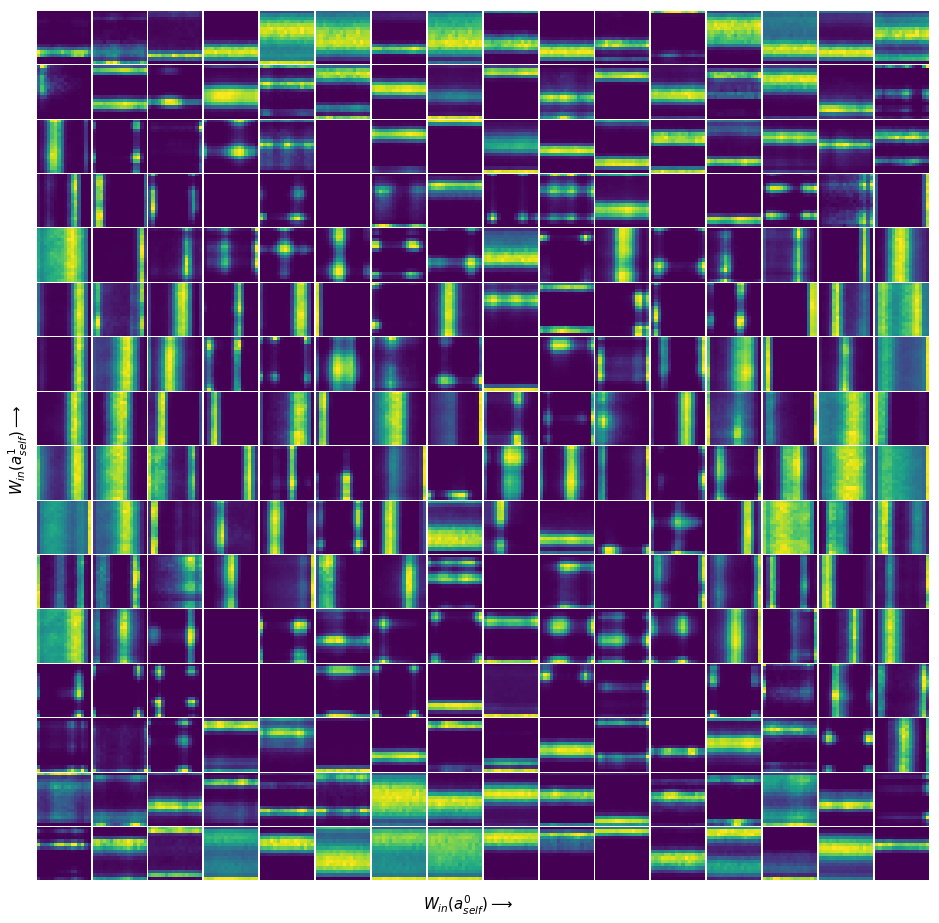

In [121]:
from scipy.stats import binned_statistic_2d

fig2,ax2 = plt.subplots(L, L, figsize=(16,16), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig2.text(0.5, 0.1, r'$W_{in} (a_{self}^0) \longrightarrow$', ha='center')
fig2.text(0.1, 0.5, r'$W_{in} (a_{self}^1) \longrightarrow$', va='center', rotation='vertical')

for cell in range(hidden.shape[-1]):
    zAvg = binned_statistic_2d(x[0,:,0].data.numpy(),
                               x[0,:,1].data.numpy(),
                               hidden[0,:,cell].data.numpy(),
                               bins=range(L+1))[0]
    ax2[cell//L,cell%L].imshow(zAvg, vmin=0)
    ax2[cell//L,cell%L].axis('off')